In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
local_zip = '/content/drive/MyDrive/University/Thesis/Thesis Project Folder/SkinDiseaseDataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

In [3]:
!pip install split-folders
import splitfolders
splitfolders.ratio('/tmp/SkinDiseaseDataset', output='/tmp/Dataset', ratio=(.6,.2,.2), group_prefix=None,seed=42)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 9655 files [00:01, 7751.78 files/s]


In [4]:
import numpy as np
import pandas as pd
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout

In [5]:
#Start
train_data_path = '/tmp/Dataset/train'
valid_data_path ='/tmp/Dataset/val'
test_data_path = '/tmp/Dataset/test'

In [6]:
#Hyperparameters
img_rows = 224
img_cols = 224
epochs = 10
batch_size = 32

In [7]:
#Image Generator
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(train_data_path,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle= True,
                                                    seed=42)

validation_generator = train_datagen.flow_from_directory(valid_data_path,
                                                        target_size=(img_rows, img_cols),
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        shuffle=True,
                                                        seed=42)

test_generator = test_datagen.flow_from_directory(test_data_path,
                                                        target_size=(img_rows, img_cols),
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        shuffle=False)

Found 5792 images belonging to 3 classes.
Found 1930 images belonging to 3 classes.
Found 1933 images belonging to 3 classes.


In [8]:
base = Xception(include_top=False, 
                weights='imagenet', 
                input_shape=(224,224,3))
x = base.output
x = GlobalAveragePooling2D()(x)
head = Dense(3, activation='softmax')(x)
model = Model(inputs=base.input, outputs=head)

model.compile(
  loss='categorical_crossentropy',
  optimizer=Adam(lr=0.0001),
  metrics=['accuracy']
)

83683744/83683744 [==============================] - 4s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
#Train
history=model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator))

Epoch 1/10
181/181 [==============================] - 160s 764ms/step - loss: 0.1666 - accuracy: 0.9380 - val_loss: 0.0424 - val_accuracy: 0.9829
Epoch 2/10
181/181 [==============================] - 136s 752ms/step - loss: 0.0497 - accuracy: 0.9827 - val_loss: 0.0261 - val_accuracy: 0.9912
Epoch 3/10
181/181 [==============================] - 135s 743ms/step - loss: 0.0286 - accuracy: 0.9907 - val_loss: 0.0210 - val_accuracy: 0.9912
Epoch 4/10
181/181 [==============================] - 137s 758ms/step - loss: 0.0277 - accuracy: 0.9910 - val_loss: 0.0179 - val_accuracy: 0.9943
Epoch 5/10
181/181 [==============================] - 138s 762ms/step - loss: 0.0185 - accuracy: 0.9941 - val_loss: 0.0183 - val_accuracy: 0.9927
Epoch 6/10
181/181 [==============================] - 135s 744ms/step - loss: 0.0210 - accuracy: 0.9927 - val_loss: 0.0254 - val_accuracy: 0.9912
Epoch 7/10
181/181 [==============================] - 144s 793ms/step - loss: 0.0204 - accuracy: 0.9924 - val_loss: 0.0198 -

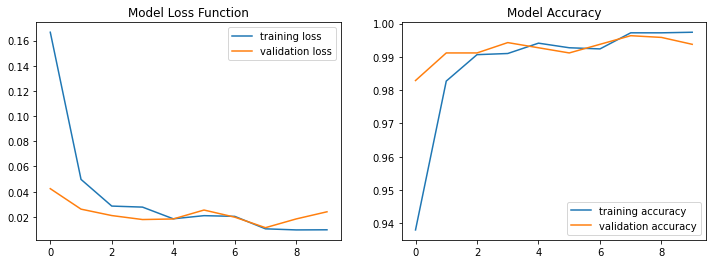

In [10]:
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_df['loss'], label='training loss')
plt.plot(history_df['val_loss'], label='validation loss')
plt.title('Model Loss Function')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_df['accuracy'], label='training accuracy')
plt.plot(history_df['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.legend();

In [11]:
# Predicting labels from X_test data
y_pred = model.predict(test_generator)

# Argmax returns the position of the largest value
y_pred_classes = np.argmax(y_pred, axis = 1)

61/61 [==============================] - 9s 138ms/step


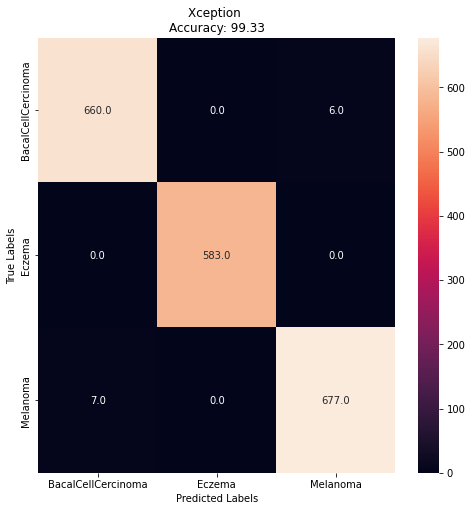

In [12]:
# Create the confusion matrix
confmx = confusion_matrix(test_generator.classes, y_pred_classes)
cm_df = pd.DataFrame(confmx,
                     
                     index = ['BacalCellCercinoma' ,'Eczema' ,'Melanoma'], 
                     columns = ['BacalCellCercinoma' ,'Eczema' ,'Melanoma'])

f, ax = plt.subplots(figsize = (8,8))
sns.heatmap(cm_df, annot=True, fmt='.1f', ax = ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Xception \nAccuracy: {0:.2f}'.format(accuracy_score(test_generator.classes, y_pred_classes)*100))
plt.show();

In [13]:
report = pd.DataFrame(classification_report(y_true = test_generator.classes, y_pred = y_pred_classes, output_dict=True)).transpose()
report = report.rename(index={'0': 'BacalCellCercinoma','1':'Eczema','2':'Melanoma'})
report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
report

,precision,recall,f1-score,support
BacalCellCercinoma,98.95,99.10,99.02,666.000000
Eczema,100.00,100.00,100.00,583.000000
Melanoma,99.12,98.98,99.05,684.000000
accuracy,99.33,99.33,99.33,0.993275
macro avg,99.36,99.36,99.36,1933.000000
weighted avg,99.33,99.33,99.33,1933.000000
